In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Preparing data for segmentation task

In [3]:
path_to_images_dir = "/kaggle/input/flood-area-segmentation/Image"
path_to_masks_dir = "/kaggle/input/flood-area-segmentation/Mask"

img_height, img_width = 128, 128 
batch_size = 16 

In [4]:
metadata = pd.read_csv("/kaggle/input/flood-area-segmentation/metadata.csv")
metadata.head()

,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   290 non-null    object
 1   Mask    290 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB


In [6]:
def load_data(df, images_path, masks_path, img_height, img_width):
    images = []
    masks = []
    
    for _, row in df.iterrows():
        img_path = os.path.join(images_path, row["Image"])
        img = load_img(img_path, target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0
        images.append(img)
        
        mask_path = os.path.join(masks_path, row["Mask"])
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        masks.append(mask)
    
    return np.array(images), np.array(masks)

In [7]:
images, masks = load_data(metadata, path_to_images_dir, path_to_masks_dir, img_height, img_width)

In [8]:
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

Images shape: (290, 128, 128, 3)
Masks shape: (290, 128, 128, 1)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(f"Size of training set: {X_train.shape}, {y_train.shape}")
print(f"Size of validation set: {X_val.shape}, {y_val.shape}")
print(f"Size of test set: {X_test.shape}, {y_test.shape}")

Size of training set: (232, 128, 128, 3), (232, 128, 128, 1)
Size of validation set: (29, 128, 128, 3), (29, 128, 128, 1)
Size of test set: (29, 128, 128, 3), (29, 128, 128, 1)


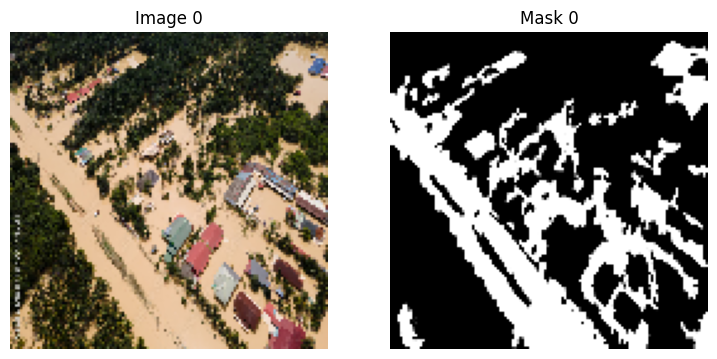

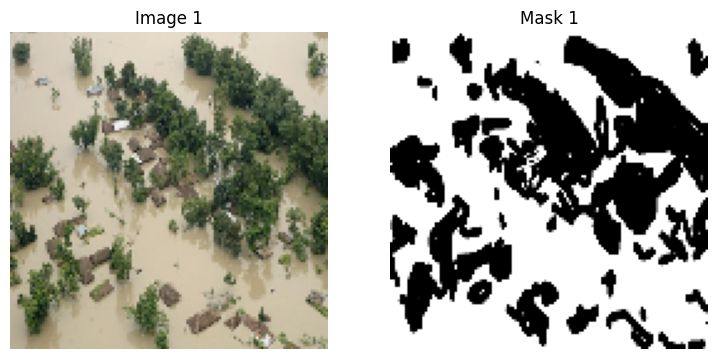

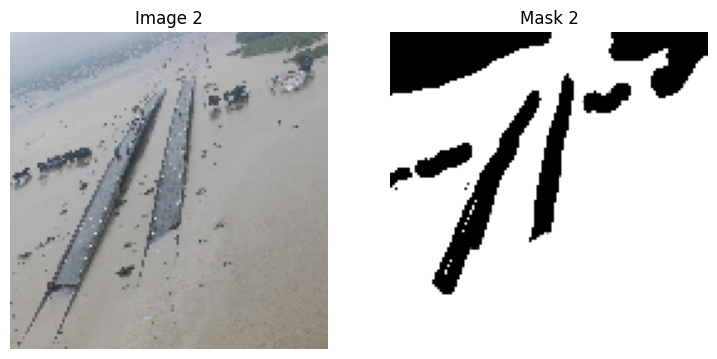

In [11]:
import matplotlib.pyplot as plt
for i in range(3):
    plt.figure(figsize=(9, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title(f"Image {i}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(y_train[i].squeeze(), cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis('off')

    plt.show()

# Building a model

In [13]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3) 
    
    u1 = UpSampling2D((2, 2))(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = UpSampling2D((2, 2))(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    return Model(inputs, outputs)

model = unet_model()

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 128)    │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_17[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64, 64, 384)    │              0 │ up_sampling2d_2[0][0], │
│ (Concatenate)             │                        │                │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 64, 64, 128)    │        442,496 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 128, 128, 128)  │              0 │ conv2d_19[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 128, 128, 192)  │              0 │ up_sampling2d_3[0][0], │
│ (Concatenate)             │                        │                │ conv2d_12[0][0]        │
├──────────────────────

 Total params: 2,473,217 (9.43 MB)

 Trainable params: 2,473,217 (9.43 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=batch_size,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6161 - loss: 0.6988 - val_accuracy: 0.7292 - val_loss: 0.6014 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6637 - loss: 0.6228 - val_accuracy: 0.6053 - val_loss: 0.5729 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6983 - loss: 0.5421 - val_accuracy: 0.7766 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7791 - loss: 0.4786 - val_accuracy: 0.7662 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7975 - loss: 0.4504 - val_accuracy: 0.7961 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7890 - loss: 0.4446 - val_accuracy: 0.8030 - val_loss: 0.4435 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.8006 - loss: 0.4424 - va

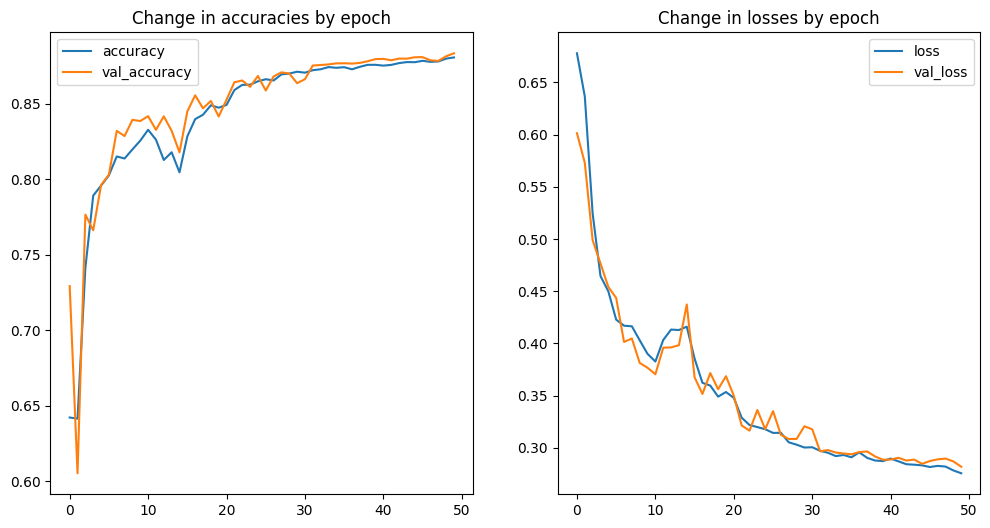

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(history.history['accuracy'], label='accuracy', ax= axs[0])
sns.lineplot(history.history['val_accuracy'], label='val_accuracy', ax= axs[0])
axs[0].set_title("Change in accuracies by epoch")
sns.lineplot(history.history['loss'], label='loss', ax= axs[1])
sns.lineplot(history.history['val_loss'], label='val_loss', ax= axs[1])
axs[1].set_title("Change in losses by epoch")
plt.show()

# Analysing the results

In [21]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [32]:
y_test_flat = y_test.flatten().astype(int)
y_pred_flat = y_pred.flatten()

iou = jaccard_score(y_test_flat, y_pred_flat)
print(f"IoU (Jaccard Index): {iou:.4f}")

dice = f1_score(y_test_flat, y_pred_flat)
print(f"Dice Coefficient: {dice:.4f}")

accuracy = (y_test_flat == y_pred_flat).mean()
print(f"Pixel Accuracy: {accuracy:.4f}")

IoU (Jaccard Index): 0.7308
Dice Coefficient: 0.8444
Pixel Accuracy: 0.8786


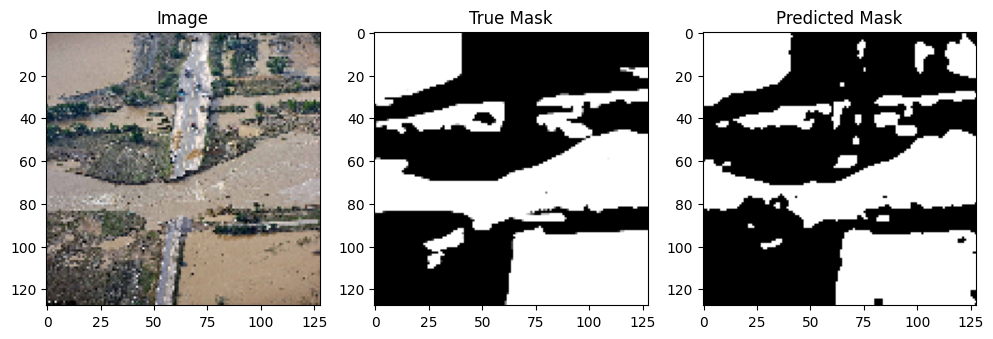

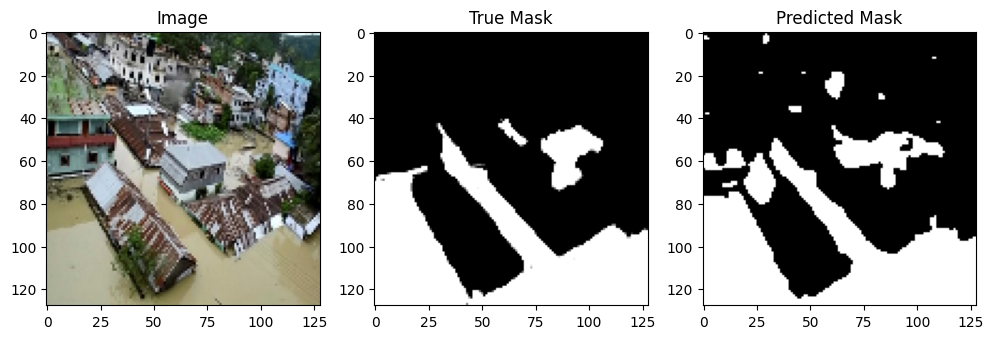

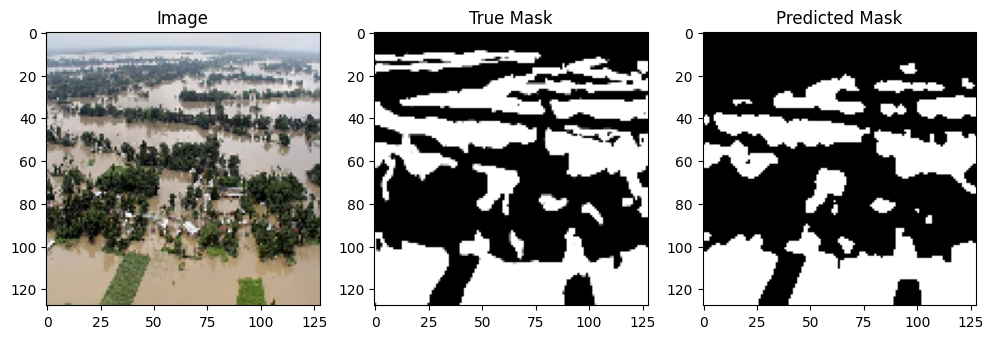

In [31]:
def visualize_prediction(image, true_mask, pred_mask):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap="gray")
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    
    plt.show()

for i in range(3):
    visualize_prediction(X_test[i], y_test[i], y_pred[i])